In [25]:
!pip install pandas scikit-learn implicit numpy seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 35.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.9/303.9 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 44.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 34.3 MB/s eta 0:00:00


In [16]:
import pandas as pd
import numpy as np

In [11]:
# Carregar o dataset
dataset_path = 'laptops_info.csv'
laptops_df = pd.read_csv(dataset_path)

# Visualizar as primeiras linhas do dataset
laptops_df.head()

brand              object
laptop_name        object
display_size      float64
processor_type     object
graphics_card      object
disk_space         object
discount_price    float64
old_price         float64
ratings_5max       object
dtype: object


In [13]:
# Extrair o número da avaliação
laptops_df["rating_float"] = laptops_df["ratings_5max"].str.split("/").str[0]

# Converter para float
laptops_df["rating_float"] = laptops_df["rating_float"].astype(float)

      brand                       laptop_name  display_size  \
0        HP              Notebook 14-df0008nx          14.0   
1    Lenovo                IdeaPad 330S-14IKB          14.0   
2    Huawei                  MateBook D Volta          14.0   
3      Dell                  Inspiron 15 3567          15.6   
4      Asus                VivoBook 15 X510UR          15.6   
..      ...                               ...           ...   
200  Lenovo               IdeaPad 320-15IKBRN          15.6   
201  Huawei                        MateBook D          15.6   
202   Apple  MacBook Pro (Retina + Touch Bar)          15.4   
203   Apple  MacBook Pro (Retina + Touch Bar)          15.4   
204    Dell                  Inspiron 15 3576          15.6   

            processor_type                  graphics_card  \
0      Intel Celeron N4000          Intel HD Graphics 600   
1      Intel Core i5-8250U         Intel UHD Graphics 620   
2      Intel Core i5-8250U    NVIDIA GeForce MX150 (2 GB)   

---------------------------------------------------------------------------

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar o dataset de informações de laptops
dataset = pd.read_csv('laptops_info.csv')
dataset = dataset.dropna()

# Extrair o número da avaliação
dataset["rating_float"] = dataset["ratings_5max"].str.split("/").str[0]

# Converter para float
dataset["rating_float"] = dataset["rating_float"].astype(float)

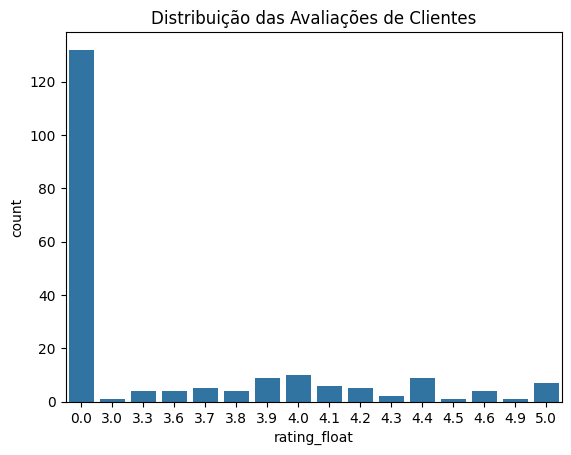

In [35]:
# Distribuição das avaliações de clientes
sns.countplot(x='rating_float', data=dataset)
plt.title('Distribuição das Avaliações de Clientes')
plt.show()

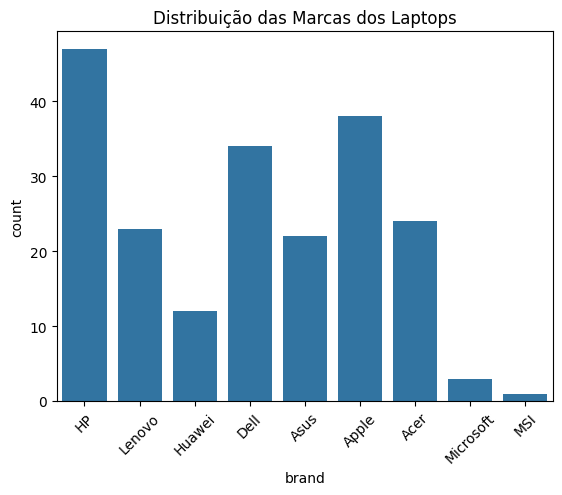

In [37]:
# Distribuição das marcas dos laptops
sns.countplot(x='brand', data=dataset)
plt.title('Distribuição das Marcas dos Laptops')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_4150/1565309529.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, avaliacoes_por_marca[i], avaliacoes_por_marca[i], ha='center', va='bottom')


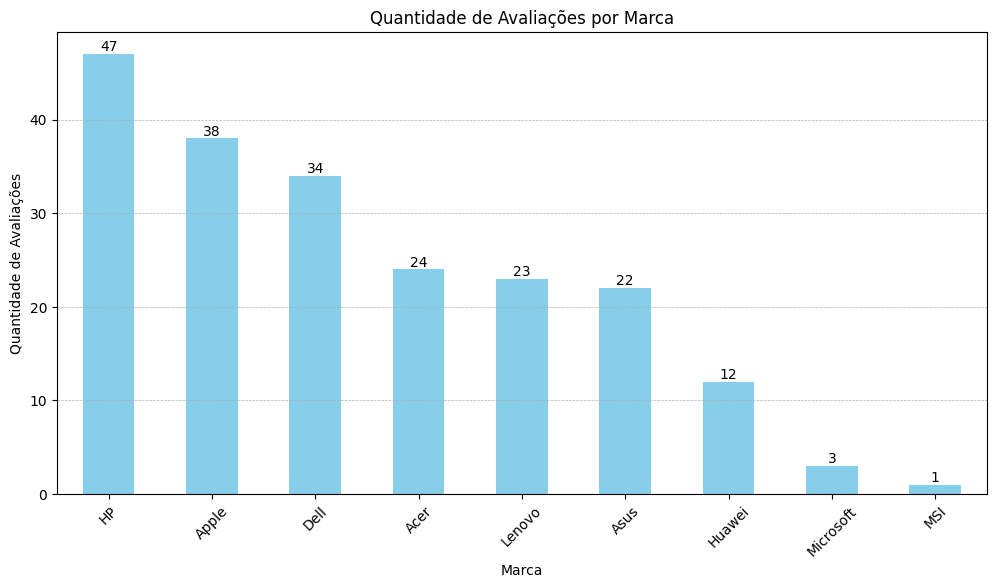

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Contar a quantidade de avaliações por marca
avaliacoes_por_marca = dataset['brand'].value_counts()

# Plotar um gráfico de barras com as marcas mais avaliadas
plt.figure(figsize=(12, 6))
avaliacoes_por_marca.plot(kind='bar', color='skyblue')
plt.title('Quantidade de Avaliações por Marca')
plt.xlabel('Marca')
plt.ylabel('Quantidade de Avaliações')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)

# Adicionar os valores das barras no gráfico
for i in range(len(avaliacoes_por_marca)):
    plt.text(i, avaliacoes_por_marca[i], avaliacoes_por_marca[i], ha='center', va='bottom')
    
plt.show()

In [42]:
import pandas as pd

# Definir um limite de avaliação para considerar um laptop como recomendado
limite_avaliacao = 4.0

# Calcular a probabilidade de recomendação de um laptop com base na avaliação
total_laptops = len(dataset)
total_recomendados = len(dataset[dataset['rating_float'] >= limite_avaliacao])
probabilidade_recomendacao = total_recomendados / total_laptops

# Exibir a probabilidade de recomendação
print("Probabilidade de um laptop ser recomendado:", probabilidade_recomendacao)

Probabilidade de um laptop ser recomendado: 0.22058823529411764
